In [51]:
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv("../Data-prep/valid_descriptor_dataset.csv")  # Adjust filename if needed

# Define column name for Curie temperature
temperature_col = "Temperature_K"

# Threshold and fraction to drop
low_temp_threshold = 290
fraction_to_drop = 0.04  # Drop 50% of the low-temperature samples (adjustable)

# Step 1: Identify low-Tc entries
low_temp_df = df[df[temperature_col] < low_temp_threshold]
high_temp_df = df[df[temperature_col] >= low_temp_threshold]

# Step 2: Randomly drop a fraction from low-Tc entries
np.random.seed(42)  # For reproducibility
num_to_drop = int(len(low_temp_df) * fraction_to_drop)
low_temp_sampled = low_temp_df.sample(n=(len(low_temp_df) - num_to_drop), random_state=42)

# Step 3: Combine with high-Tc entries
df_balanced = pd.concat([low_temp_sampled, high_temp_df]).reset_index(drop=True)

# Step 4: Save the balanced dataset
df_balanced.to_csv("balanced_curie_temperatures.csv", index=False)

# Report
print(f"Original dataset size: {len(df)}")
print(f"Low-Tc entries before: {len(low_temp_df)}")
print(f"Low-Tc entries after:  {len(low_temp_sampled)}")
print(f"\n --> Balanced dataset size: {len(df_balanced)}")


Original dataset size: 13116
Low-Tc entries before: 6473
Low-Tc entries after:  6215

 --> Balanced dataset size: 12858


In [52]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import winsound
from scipy.stats import zscore


# Load dataset
df = pd.read_csv("balanced_curie_temperatures.csv")

# Top features (manually selected or from importance_df)
features = list(df.columns.values[2:])

target = "Temperature_K"

# Drop rows with missing values
df_clean = df.dropna(subset=features + [target])

print(f"Dataset size after dropna: {len(df_clean)}")


# Features and target
X = df_clean[features]
y = df_clean[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = ExtraTreesRegressor(n_estimators = 100, min_samples_split=3,random_state=42) #, max_depth=16
model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 ExtraTrees Regressor (Test Set Results):")
print(f"MAE:  {mae:.2f} K")
print(f"RMSE: {rmse:.2f} K")
print(f"R²:   {r2:.4f}")





Dataset size after dropna: 12804

📊 ExtraTrees Regressor (Test Set Results):
MAE:  52.19 K
RMSE: 100.91 K
R²:   0.8411


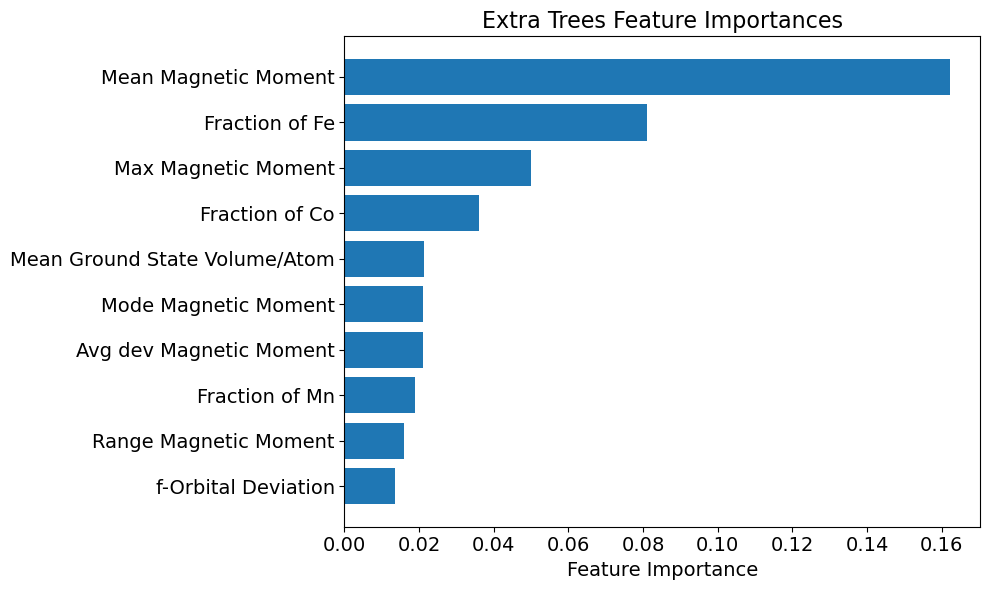

In [53]:
import matplotlib.pyplot as plt


import json
with open("column_name_dictionary.json", "r") as f:
    name_map = json.load(f)

    
# Get importances
importances = model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Apply readable names
importance_df["Readable Feature"] = importance_df["Feature"].apply(lambda f: name_map.get(f, f))


# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Readable Feature"][:10], importance_df["Importance"][:10])

# Increase font sizes
plt.xlabel("Feature Importance", fontsize=14)
plt.title("Extra Trees Feature Importances", fontsize=16)

# Increase tick label font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance_extra_trees.png")
plt.show()


In [54]:
temp = importance_df[importance_df['Importance']>0.001]
weak_features = list(importance_df[importance_df['Importance']<0.001]['Feature'])

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import json

# === Load readable feature names ===
with open("column_name_dictionary.json", "r") as f:
    name_map = json.load(f)

# Replace column names in X using the dictionary
X_readable = X.rename(columns=lambda col: name_map.get(col, col))

# === Compute SHAP values ===
explainer = shap.Explainer(model, X_readable)
shap_values = explainer(X_readable, check_additivity=False)

# === Get top 10 features based on mean absolute SHAP value ===
shap_df = pd.DataFrame(shap_values.values, columns=X_readable.columns)
top_10 = shap_df.abs().mean().sort_values(ascending=False).head(10).index.tolist()

# === SHAP summary bar plot (Top 10 only) ===
shap.plots.bar(shap_values[:, top_10], show=False)
plt.tight_layout()
plt.savefig("shap_summary_bar_top10.png")
plt.show()

# === SHAP beeswarm plot (Top 10 only) ===
shap.plots.beeswarm(shap_values[:, top_10], show=False)
plt.tight_layout()
plt.savefig("shap_beeswarm_top10.png")
plt.show()


In [56]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("../Data-prep/valid_descriptor_dataset.csv")

##### # Top features 
top_features = list(temp['Feature'].values[:])  #list(temp['Feature'].values[:]) #

target = "Temperature_K"

# Drop rows with missing values
df_clean = df.dropna(subset=top_features + [target])

# Features and target
X = df_clean[top_features]
y = df_clean[target]

# === Step 4: KMeans clustering ===
n_clusters = 4 # You can tune this
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_clean["Cluster"] = kmeans.fit_predict(X)

# === Step 5: Train ExtraTrees per cluster ===
results = []

for cluster_id in range(n_clusters):
    cluster_df = df_clean[df_clean["Cluster"] == cluster_id]
    X = cluster_df[features]
    y = cluster_df[target]

    if len(cluster_df) < 20:
        print(f"⚠️ Cluster {cluster_id} has too few samples ({len(cluster_df)}) — skipping.")
        continue

    # Train-test split (80/20)
    train_frac = 0.8
    train_size = int(len(X) * train_frac)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Train model
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n📊 Cluster {cluster_id} | Size: {len(cluster_df)}")
    print(f"MAE:  {mae:.2f} K")
    print(f"RMSE: {rmse:.2f} K")
    print(f"R²:   {r2:.4f}")

    results.append({
        "Cluster": cluster_id,
        "Size": len(cluster_df),
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

# === Step 6: Summary DataFrame ===
summary = pd.DataFrame(results)
summary.to_csv("extratrees_per_cluster_results.csv", index=False)
print("\n✅ Results saved to 'extratrees_per_cluster_results.csv'")

df_clean_clusters=df_clean.copy()

C:\Users\Adeel\AppData\Local\Temp\ipykernel_30380\4226292707.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Cluster"] = kmeans.fit_predict(X)



📊 Cluster 0 | Size: 4744
MAE:  86.83 K
RMSE: 135.39 K
R²:   0.7989

📊 Cluster 1 | Size: 4826
MAE:  100.21 K
RMSE: 158.22 K
R²:   0.5855

📊 Cluster 2 | Size: 2730
MAE:  88.68 K
RMSE: 136.17 K
R²:   0.7348

📊 Cluster 3 | Size: 760
MAE:  138.88 K
RMSE: 254.85 K
R²:   0.3844

✅ Results saved to 'extratrees_per_cluster_results.csv'


In [57]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.ensemble import ExtraTreesRegressor

# Load column name dictionary
with open("column_name_dictionary.json", "r") as f:
    name_map = json.load(f)

# SHAP analysis for each cluster
for cluster_id in range(n_clusters):
    cluster_df = df_clean[df_clean["Cluster"] == cluster_id]
    X_cluster = cluster_df[top_features]
    y_cluster = cluster_df[target]

    if len(X_cluster) < 20:
        print(f"⚠️ Cluster {cluster_id} has too few samples ({len(X_cluster)}) — skipping SHAP.")
        continue

    print(f"🔎 SHAP analysis for Cluster {cluster_id} — {len(X_cluster)} samples")

    # Replace feature names for readability
    X_cluster_readable = X_cluster.rename(columns=lambda col: name_map.get(col, col))

    # Train a new model
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    model.fit(X_cluster_readable, y_cluster)

    # Create SHAP explainer
    explainer = shap.Explainer(model, X_cluster_readable)
    shap_values = explainer(X_cluster_readable, check_additivity=False)

    # Compute mean absolute SHAP values
    shap_df = pd.DataFrame(shap_values.values, columns=X_cluster_readable.columns)
    top_10 = shap_df.abs().mean().sort_values(ascending=False).head(10).index.tolist()

    # Summary bar plot (top 10)
    shap.plots.bar(shap_values[:, top_10], show=False)
    plt.title(f"SHAP Summary Bar - Cluster {cluster_id}")
    plt.tight_layout()
    plt.savefig(f"shap_summary_bar_cluster_{cluster_id}.png")
    plt.close()

    # Beeswarm plot (top 10)
    shap.plots.beeswarm(shap_values[:, top_10], show=False)
    plt.title(f"SHAP Beeswarm - Cluster {cluster_id}")
    plt.tight_layout()
    plt.savefig(f"shap_beeswarm_cluster_{cluster_id}.png")
    plt.close()


🔎 SHAP analysis for Cluster 0 — 4744 samples


100%|===================| 4743/4744 [20:22<00:00]        

🔎 SHAP analysis for Cluster 1 — 4826 samples


100%|===================| 4824/4826 [22:30<00:00]        

🔎 SHAP analysis for Cluster 2 — 2730 samples


100%|===================| 2726/2730 [13:12<00:01]        

🔎 SHAP analysis for Cluster 3 — 760 samples


 99%|===================| 750/760 [01:13<00:00]        

In [63]:

# Select only numeric columns
numeric_cols = df_clean.select_dtypes(include='number').columns

# Group by cluster and compute mean and std
summary = df_clean.groupby("Cluster")[['Temperature_K']+top_features].agg(['mean', 'std'])

# Optional: round the results for readability
summary = summary.round(4)

# Display summary
print(summary)


# Save to CSV if needed
summary.to_csv("clusterwise_feature_stats.csv")

        Temperature_K           MagpieData mean GSmagmom         el_frac_Fe  \
                 mean       std                     mean     std       mean   
Cluster                                                                       
0            371.5336  281.1492                   0.9184  0.6497     0.3056   
1            290.9067  225.8367                   0.1864  0.2709     0.0681   
2            309.9152  242.6795                   0.4941  0.5447     0.1512   
3            397.3576  265.0678                   0.8459  0.7502     0.3540   

                MagpieData maximum GSmagmom         el_frac_Co          ...  \
            std                        mean     std       mean     std  ...   
Cluster                                                                 ...   
0        0.3488                      1.4940  0.8161     0.1450  0.2505  ...   
1        0.1214                      0.8662  0.9686     0.0228  0.0634  ...   
2        0.2653                      1.0683  0.9008